In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, cross_validate

plt.style.use("ggplot")

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Random Forest interpolation of RESA2 data

Spatio-temporal interpolation of all Norwegian RESA2 data using a Random Forest. 

In [3]:
# Parameter of interest
par = "TOTN"

# Total training interval
st_yr, end_yr = 1980, 2019

# Stations to plot for testing
test_stn_ids = [
    30019,
    29612,
    29779,
    29820,
    29821,
    29822,
    29782,
    36225,
    29832,
    29783,
    29837,
    29842,
    29844,
    29778,
    29613,
    29848,
    29614,
    29615,
    29617,
]

# Whether to omit 'test_stn_ids' from the training data
omit_test_stns = True

# Use periodic features for month and day_of_year
use_periodic = False

# Whether to use runoff from the GTS API as an additional feature
# NOTE: Setting this to true takes a long time (~15 mins) and requires
# a machine with high memory
use_runoff = True

In [4]:
def encode(data, col, max_val):
    """Generate periodic features using sin and cos."""
    data = data.copy()
    data[col + "_sin"] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + "_cos"] = np.cos(2 * np.pi * data[col] / max_val)
    del data[col]

    return data


def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [5]:
# Read raw data
wc_csv = r"/home/jovyan/shared/common/oslofjord_modelling/resa_data_dump_2019/tidied/resa2_water_chemistry.csv"
stn_csv = r"/home/jovyan/shared/common/oslofjord_modelling/resa_data_dump_2019/tidied/resa2_stations.csv"
wc_df = pd.read_csv(wc_csv)
stn_df = pd.read_csv(stn_csv)

# Filter stations to mainland Norway
nor_gdf = nivapy.da.read_postgis("cultural", "norway_kartverket_fylker_2019_poly", eng)
nor_gdf["dissolve"] = 1
nor_gdf = nor_gdf.dissolve(by="dissolve")[["id", "geom"]]
stn_df = nivapy.spatial.identify_point_in_polygon(
    stn_df,
    nor_gdf,
    pt_col="station_id",
    poly_col="id",
    lat_col="latitude",
    lon_col="longitude",
)
stn_df.dropna(subset="id", inplace=True)
nivapy.spatial.quickmap(stn_df, cluster=True)

/tmp/ipykernel_3523/3173030316.py:4: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  wc_df = pd.read_csv(wc_csv)


In [6]:
# # Get runoff from GTS API. Takes about an hour and needs a high memory machine.
# # Only needs running once, then save the result to 'shared' for reuse later
# pars = ["gwb_q"]
# ro_df = nivapy.da.get_nve_gts_api_time_series(
#     stn_df,
#     pars,
#     f"{st_yr}-01-01",
#     f"{end_yr}-12-31",
#     id_col="station_id",
#     xcol="longitude",
#     ycol="latitude",
#     crs="epsg:4326",
# )
# ro_csv = r"/home/jovyan/shared/common/oslofjord_modelling/resa_data_dump_2019/machine_learning/resa_nve_gts-api_runoff.csv"
# ro_df.to_csv(ro_csv, index=False)
# ro_df.head()

In [7]:
if use_runoff:
    ro_csv = r"/home/jovyan/shared/common/oslofjord_modelling/resa_data_dump_2019/machine_learning/resa_nve_gts-api_runoff.csv"
    ro_df = pd.read_csv(ro_csv, usecols=["station_id", "datetime", "value"], engine="c")
    ro_df["datetime"] = pd.to_datetime(ro_df["datetime"])
    ro_df["year"] = ro_df["datetime"].dt.year
    ro_df["month"] = ro_df["datetime"].dt.month
    ro_df["day"] = ro_df["datetime"].dt.day
    ro_df = ro_df[["station_id", "year", "month", "day", "value"]]
    ro_df.rename({"value": "runoff_mm"}, axis="columns", inplace=True)

In [8]:
# Convert to UTM Zone 33 so distances are roughly isometric
stn_df = nivapy.spatial.wgs84_dd_to_utm(
    stn_df, lat="latitude", lon="longitude", utm_zone=33
)

# Build features of interest
wc_df = wc_df.query("parameter_name == @par")
wc_df["sample_date"] = pd.to_datetime(wc_df["sample_date"])
df = pd.merge(wc_df, stn_df, how="left", on="station_id")
df["year"] = df["sample_date"].dt.year
df["month"] = df["sample_date"].dt.month
df["day"] = df["sample_date"].dt.day
df["day_of_year"] = df["sample_date"].dt.dayofyear
df = df.query("@st_yr <= year <= @end_yr")
idx_cols = cols = [
    "station_id",
    "utm_east",
    "utm_north",
    "year",
    "month",
    "day",
    "day_of_year",
]
if use_runoff:
    df = pd.merge(df, ro_df, how="left", on=["station_id", "year", "month", "day"])
    val_cols = ["runoff_mm", "value"]
else:
    val_cols = ["value"]
df = df[idx_cols + val_cols].dropna()
df = df.groupby(idx_cols).mean().reset_index()

df.head()

,station_id,utm_east,utm_north,year,month,day,day_of_year,runoff_mm,value
0,1,139454.180493,6.973725e+06,2003,6,24,175,0.5,71.0
1,1,139454.180493,6.973725e+06,2003,6,28,179,0.4,60.0
2,1,139454.180493,6.973725e+06,2003,7,15,196,0.4,68.0
3,1,139454.180493,6.973725e+06,2003,8,15,227,2.8,280.0
4,1,139454.180493,6.973725e+06,2003,9,14,257,1.1,220.0


In [9]:
# Remove test stations from training data
if omit_test_stns:
    train_df = df.query("station_id not in @test_stn_ids").copy()
else:
    train_df = df.copy()
test_df = df.query("station_id in @test_stn_ids").copy()

In [10]:
# Split the data into features (X) and target (y)
X = train_df.drop(["station_id", "value"], axis="columns")
y = train_df["value"]

if use_periodic:
    X = encode(X, "month", 12)
    X = encode(X, "day", 31)
    X = encode(X, "day_of_year", 366)

OOB R2: 0.41


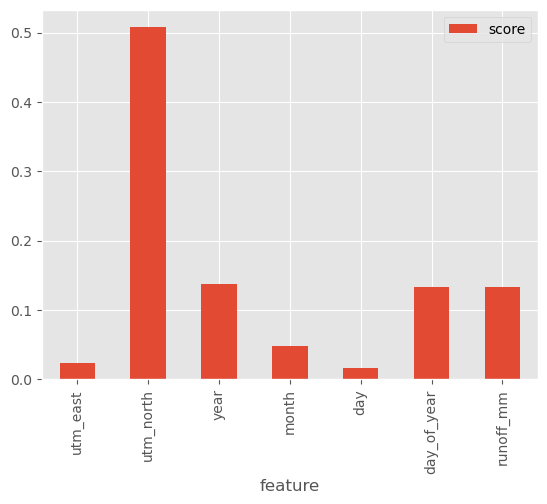

In [11]:
# Build model
model = RandomForestRegressor(
    random_state=17,
    n_estimators=100,
    max_depth=None,
    n_jobs=10,
    oob_score=True,
)

# # Evaluation using CV
# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
# evaluate(model, X, y, cv=cv)

# Or just fit to full dataset and use the OOB Score, plus predictions for 'test_stn_id'
model.fit(X, y)
feat_imps = pd.DataFrame(
    zip(X.columns, model.feature_importances_),
    columns=["feature", "score"],
).set_index("feature")
feat_imps.plot(kind="bar")
print(f"OOB R2: {model.oob_score_:.2f}")

In [12]:
pred_st, pred_end = 2013, 2019

In [13]:
# Get measured data for test station (not used in fitting model)
test_stn_df = stn_df.query("station_id in @test_stn_ids")
obs_df = test_df.query(f"{pred_st} <= year < {pred_end + 1}").copy()
obs_df.rename({"value": "observed"}, axis="columns", inplace=True)

# Predictions for test stations
dates = pd.date_range(f"{pred_st}-01-01", f"{pred_end}-12-31", freq="D")
df_list = []
for test_stn_id in test_stn_ids:
    stn_pred_df = pd.DataFrame(
        {
            "sample_date": dates,
            "station_id": test_stn_id,
        }
    )
    stn_pred_df["year"] = stn_pred_df["sample_date"].dt.year
    stn_pred_df["month"] = stn_pred_df["sample_date"].dt.month
    stn_pred_df["day"] = stn_pred_df["sample_date"].dt.day
    stn_pred_df["day_of_year"] = stn_pred_df["sample_date"].dt.dayofyear
    del stn_pred_df["sample_date"]
    df_list.append(stn_pred_df)

pred_df = pd.concat(df_list, axis="rows")
if use_runoff:
    pred_df = pd.merge(
        pred_df,
        ro_df,
        how="left",
        on=["station_id", "year", "month", "day"],
    )
pred_df = pd.merge(
    pred_df,
    test_stn_df[["station_id", "utm_east", "utm_north"]],
    how="left",
    on="station_id",
)
if use_periodic:
    pred_df = encode(pred_df, "month", 12)
    pred_df = encode(pred_df, "day", 31)
    pred_df = encode(pred_df, "day_of_year", 365)
pred_df = pred_df[X.columns]
pred_df["predicted"] = model.predict(pred_df)
pred_df = pd.merge(
    pred_df,
    obs_df[["utm_east", "utm_north", "station_id"]],
    how="left",
    on=["utm_east", "utm_north"],
)
pred_df = pd.merge(
    pred_df,
    obs_df,
    how="left",
    on=["station_id", "utm_east", "utm_north", "year", "month", "day", "day_of_year"],
)
pred_df["date"] = pd.to_datetime(pred_df[["year", "month", "day"]])
pred_df = pred_df[["station_id", "date", "predicted", "observed"]]
pred_df.head()

,station_id,date,predicted,observed
0,30019,2013-01-01,471.68,NaN
1,30019,2013-01-01,471.68,NaN
2,30019,2013-01-01,471.68,NaN
3,30019,2013-01-01,471.68,NaN
4,30019,2013-01-01,471.68,NaN


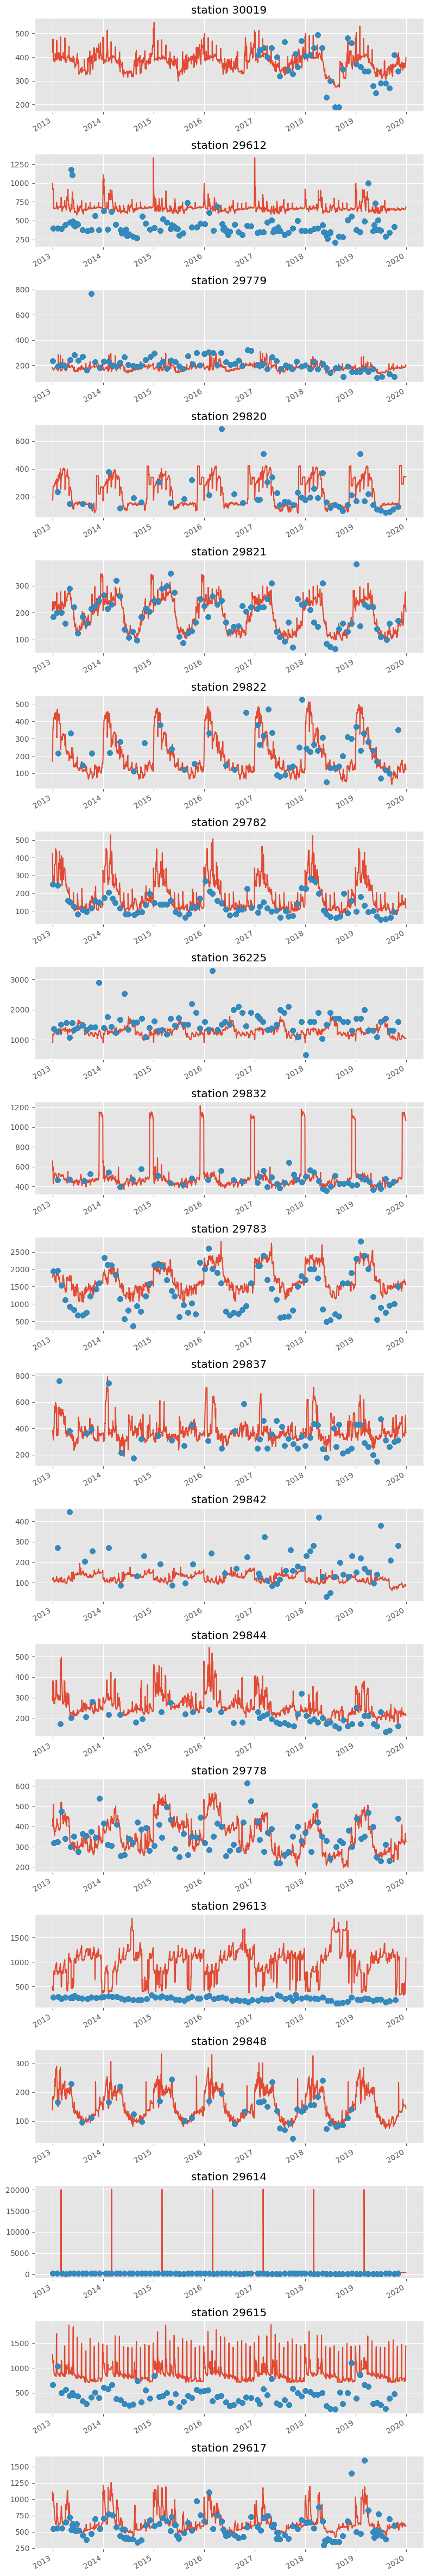

In [14]:
fig, axes = plt.subplots(
    ncols=1, nrows=len(test_stn_ids), figsize=(8, 2.5 * len(test_stn_ids))
)
for idx, stn_id in enumerate(test_stn_ids):
    ax = axes[idx]
    data_df = pred_df.query("station_id == @stn_id").set_index("date")
    data_df[["predicted"]].plot(ax=ax, legend=False)
    data_df[["observed"]].plot(marker="o", linestyle="none", ax=ax, legend=False)
    ax.set_title(f"station {stn_id}")
    ax.set_xlabel('')
plt.tight_layout()
if omit_test_stns:
    plt.savefig('exclude_test_stns.png', dpi=150)
else:
    plt.savefig('include_test_stns.png', dpi=150)